In [14]:
import numpy as np
import matplotlib.pyplot as plt

def one_hot_encode(labels, n_labels):
   
    assert np.min(labels) >= 0 and np.max(labels) < n_labels

    y = np.zeros([labels.size, n_labels])
    y[range(labels.size), labels] = 1

    return y

def logit(x):
   
    return np.log(x / (1.0 - x))


In [15]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
class MNIST:
    # construct dataset
    alpha = 1.0e-6
    class Data:
        
        def __init__(self, data, logit, dequantize, rng):

            x = self._dequantize(data[0], rng) if dequantize else data[0]  
            self.x = self._logit_transform(x) if logit else x              
            self.labels = data[1]                                         
            self.y = util.one_hot_encode(self.labels, 10)                  
            self.N = self.x.shape[0]                                       

        @staticmethod
        # Add noise to pixels to dequantize them dequantization
        def _dequantize(x, rng):
            
            return x + rng.rand(*x.shape) / 256.0

        @staticmethod
        # Transform pixel values to unconstrained using logit
        def _logit_transform(x):
            
            return util.logit(MNIST.alpha + (1 - 2*MNIST.alpha) * x)

    def __init__(self, logit=True, dequantize=True):

        # load dataset
        f = gzip.open(datasets.root + '/mnist.pkl.gz', 'rb')
        trn,val, tst = pickle.load(f, encoding='latin1')
        f.close()

        rng = np.random.RandomState(42)
        self.trn = self.Data(trn, logit, dequantize, rng)
        self.val = self.Data(val, logit, dequantize, rng)
        self.tst = self.Data(tst, logit, dequantize, rng)

        im_dim = int(np.sqrt(self.trn.x.shape[1]))
        self.n_dims = (1, im_dim, im_dim)
        self.n_labels = self.trn.y.shape[1]
        self.image_size = [im_dim, im_dim]
    
    # Plot a histogram of pixel values
    def show_pixel_histograms(self, split, pixel=None):
        
        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        if pixel is None:
            data = data_split.x.flatten()

        else:
            row, col = pixel
            idx = row * self.image_size[0] + col
            data = data_split.x[:, idx]

        n_bins = int(np.sqrt(data_split.N))
        fig, ax = plt.subplots(1, 1)
        ax.hist(data, n_bins, normed=True)
        plt.show()

    def show_images(self, split):
        
        # get split
        data_split = getattr(self, split, None)
        if data_split is None:
            raise ValueError('Invalid data split')

        # display images
        util.disp_imdata(data_split.x, self.image_size, [6, 10])

        plt.show()


In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
def logit(x, eps=1e-5):
    x.clamp_(eps, 1 - eps)
    return x.log() - (1 - x).log()
# Convert one-hot encoding
def one_hot(x, label_size):
    out = torch.zeros(len(x), label_size).to(x.device)
    out[torch.arange(len(x)), x] = 1
    return out
# load dataset
def load_dataset(name):
    exec('from datasets.{} import {}'.format(name.lower(), name))
    return locals()[name]


# load dataset
def fetch_dataloaders(dataset_name, batch_size, device, flip_toy_var_order=False, toy_train_size=25000, toy_test_size=5000):
    if dataset_name in ['MNIST']:
        dataset = load_dataset(dataset_name)()

        # join train and val data again
        train_x = np.concatenate((dataset.trn.x, dataset.val.x), axis=0).astype(np.float32)
        train_y = np.concatenate((dataset.trn.y, dataset.val.y), axis=0).astype(np.float32)

        # construct datasets
        train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
        test_dataset  = TensorDataset(torch.from_numpy(dataset.tst.x.astype(np.float32)),
                                      torch.from_numpy(dataset.tst.y.astype(np.float32)))

        input_dims = dataset.n_dims
        label_size = 10
        lam = dataset.alpha


    train_dataset.input_dims = input_dims
    train_dataset.input_size = int(np.prod(input_dims))
    train_dataset.label_size = label_size
    train_dataset.lam = lam

    test_dataset.input_dims = input_dims
    test_dataset.input_size = int(np.prod(input_dims))
    test_dataset.label_size = label_size
    test_dataset.lam = lam


    kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == 'cuda' else {}

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **kwargs)

    return train_loader, test_loader


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T
from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import argparse
import pprint
import copy


# RealNVP Coupling
class LinearMaskedCoupling(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, mask, cond_label_size=None):
        super().__init__()
        self.register_buffer('mask', mask)
        s_net = [nn.Linear(input_size + (cond_label_size if cond_label_size is not None else 0), hidden_size)]
        for _ in range(n_hidden):
            s_net += [nn.Tanh(), nn.Linear(hidden_size, hidden_size)]
        s_net += [nn.Tanh(), nn.Linear(hidden_size, input_size)]
        self.s_net = nn.Sequential(*s_net)
        self.t_net = copy.deepcopy(self.s_net)
        for i in range(len(self.t_net)):
            if not isinstance(self.t_net[i], nn.Linear): self.t_net[i] = nn.ReLU()

    def forward(self, x, y=None):
        mx = x * self.mask
        s = self.s_net(mx if y is None else torch.cat([y, mx], dim=1))
        t = self.t_net(mx if y is None else torch.cat([y, mx], dim=1))
        u = mx + (1 - self.mask) * (x - t) * torch.exp(-s)
        log_abs_det_jacobian = - (1 - self.mask) * s
        return u, log_abs_det_jacobian

    def inverse(self, u, y=None):
        mu = u * self.mask
        s = self.s_net(mu if y is None else torch.cat([y, mu], dim=1))
        t = self.t_net(mu if y is None else torch.cat([y, mu], dim=1))
        x = mu + (1 - self.mask) * (u * s.exp() + t)  # cf RealNVP eq 7
        log_abs_det_jacobian = (1 - self.mask) * s
        return x, log_abs_det_jacobian

# RealNVP BatchNorm
class BatchNorm(nn.Module):
    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps
        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))
        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))

    def forward(self, x, cond_y=None):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0)
            # update average
            self.running_mean.mul_(self.momentum).add_(self.batch_mean.data * (1 - self.momentum))
            self.running_var.mul_(self.momentum).add_(self.batch_var.data * (1 - self.momentum))
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var
        # compute normalized input
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta

        log_abs_det_jacobian = self.log_gamma - 0.5 * torch.log(var + self.eps)
        return y, log_abs_det_jacobian.expand_as(x)

    def inverse(self, y, cond_y=None):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (y - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_abs_det_jacobian = 0.5 * torch.log(var + self.eps) - self.log_gamma
        return x, log_abs_det_jacobian.expand_as(x)

# Layers for Normalizing flows
class FlowSequential(nn.Sequential):
    def forward(self, x, y):
        sum_log_abs_det_jacobians = 0
        for module in self:
            x, log_abs_det_jacobian = module(x, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return x, sum_log_abs_det_jacobians

    def inverse(self, u, y):
        sum_log_abs_det_jacobians = 0
        for module in reversed(self):
            u, log_abs_det_jacobian = module.inverse(u, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return u, sum_log_abs_det_jacobians

# Model settings
class RealNVP(nn.Module):
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden, cond_label_size=None, batch_norm=True):
        super().__init__()

        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # construct model
        modules = []
        mask = torch.arange(input_size).float() % 2
        for i in range(n_blocks):
            modules += [LinearMaskedCoupling(input_size, hidden_size, n_hidden, mask, cond_label_size)]
            mask = 1 - mask
            modules += batch_norm * [BatchNorm(input_size)]

        self.net = FlowSequential(*modules)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        return self.net(x, y)

    def inverse(self, u, y=None):
        return self.net.inverse(u, y)

    def log_prob(self, x, y=None):
        u, sum_log_abs_det_jacobians = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + sum_log_abs_det_jacobians, dim=1)


# train and evaluate
def train_model(model, dataloader, optimizer, epoch):

    for i, data in enumerate(dataloader):
        model.train()

        # check if labeled dataset
        if len(data) == 1:
            x, y = data[0], None
        else:
            x, y = data
            y = y.to(device)
        x = x.view(x.shape[0], -1).to(device)

        loss = - model.log_prob(x, y if cond_label_size else None).mean(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print('epoch {:3d} / {}, step {:4d} / {}; loss {:.4f}'.format(
                epoch, start_epoch + n_epochs, i, len(dataloader), loss.item()))

@torch.no_grad()
def evaluate_model(model, dataloader, epoch):
    model.eval()
    # conditional model
    if cond_label_size is not None:
        logprior = torch.tensor(1 / cond_label_size).log().to(device)
        loglike = [[] for _ in range(cond_label_size)]

        for i in range(cond_label_size):
            # transfer to onehot encoding
            labels = torch.zeros(batch_size, cond_label_size).to(device)
            labels[:,i] = 1

            for x, y in dataloader:
                x = x.view(x.shape[0], -1).to(device)
                loglike[i].append(model.log_prob(x, labels))

            loglike[i] = torch.cat(loglike[i], dim=0)
        loglike = torch.stack(loglike, dim=1)
        logprobs = logprior + loglike.logsumexp(dim=1)
    # unconditional model
    else:
        logprobs = []
        for data in dataloader:
            x = data[0].view(data[0].shape[0], -1).to(device)
            logprobs.append(model.log_prob(x))
        logprobs = torch.cat(logprobs, dim=0).to(device)

    logprob_mean, logprob_std = logprobs.mean(0), 2 * logprobs.var(0).sqrt() / math.sqrt(len(dataloader.dataset))
    output = 'Evaluate ' + (epoch != None)*'(epoch {}) -- '.format(epoch) + 'logp(x) = {:.3f} +/- {:.3f}'.format(logprob_mean, logprob_std)
    print(output)
    print(output, file=open(results_file, 'a'))
    return logprob_mean, logprob_std

# generate plots
@torch.no_grad()
def generate_img(model, dataset_lam,  step=None, n_row=10):
    model.eval()
    # conditional model
    if cond_label_size:
        samples = []
        labels = torch.eye(cond_label_size).to(device)

        for i in range(cond_label_size):
            # The sample model base distribution and run through the inverse model to the sample set
            u = model.base_dist.sample((n_row, n_components)).squeeze()
            labels_i = labels[i].expand(n_row, -1)
            sample, _ = model.inverse(u, labels_i)
            log_probs = model.log_prob(sample, labels_i).sort(0)[1].flip(0)  # 按log_ prob排序；以argsort和idx为例，从高到低翻转
            samples.append(sample[log_probs])

        samples = torch.cat(samples, dim=0)

    # unconditional model
    else:
        u = model.base_dist.sample((n_row**2, n_components)).squeeze()
        samples, _ = model.inverse(u)
        log_probs = model.log_prob(samples).sort(0)[1].flip(0)
        samples = samples[log_probs]

    # save figures
    samples = samples.view(samples.shape[0], *input_dims)
    samples = (torch.sigmoid(samples) - dataset_lam) / (1 - 2 * dataset_lam)
    filename = 'generate_samples_with_' + (step != None)*'_epoch_{}'.format(step) + '.png'
    save_image(samples, os.path.join(output_dir, filename), nrow=n_row, normalize=True)

def train_and_evaluate(model, train_loader, test_loader, optimizer):
    best_eval_logprob = float('-inf')
    for i in range(start_epoch, start_epoch + n_epochs):
        train_model(model, train_loader, optimizer, i)
        eval_logprob, _ = evaluate_model(model, test_loader, i)

        # Save training checkpoint
        torch.save({'epoch': i,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict()},
                    os.path.join(output_dir, 'model_checkpoint.pt'))
        # save model
        torch.save(model.state_dict(), os.path.join(output_dir, 'model_state.pt'))

        # save optimal model
        if eval_logprob > best_eval_logprob:
            best_eval_logprob = eval_logprob
            torch.save({'epoch': i,
                        'model_state': model.state_dict(),
                        'optimizer_state': optimizer.state_dict()},
                        os.path.join(output_dir, 'best_model_checkpoint.pt'))

        # generate figures
        if dataset == 'MNIST':
            generate_img(model, train_loader.dataset.lam, step=i)



train=True  #train
evaluate=True  #evaluate
generate=True    #generate samples
model='realnvp' #model name
dataset='MNIST' #dataset name
batch_size=4000
n_epochs=400
start_epoch=0  #epoch
lr=1e-4      #learning rate
log_interval=1000  #loss

data_dir='data/' #model save file
output_dir='results/' #direction of dataset
results_file='results.txt'#save results file name

seed=1  #ramdom seed
n_blocks=5 #The number of blocks in the model
n_components=1  #The number of Gaussian clusters for the Gaussian mixture model
hidden_size=100  #hidden layer size
n_hidden=1 #number of hidden layer
flip_toy_var_order=False
no_batch_norm=False
restore_file=False

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# set cpu or gpu
device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
torch.manual_seed(seed)
if device.type == 'cuda': torch.cuda.manual_seed(seed)
# loading dataset
train_dataloader, test_dataloader = fetch_dataloaders(dataset, batch_size, device, flip_toy_var_order)
input_size = train_dataloader.dataset.input_size
input_dims = train_dataloader.dataset.input_dims
cond_label_size = None

# model settings
if model =='realnvp':
    model = RealNVP(n_blocks, input_size, hidden_size, n_hidden, cond_label_size,
                    batch_norm=not no_batch_norm)
else:
    raise ValueError('Please use a model of normalizing flows.')

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

if restore_file:
    # Model and optimizer status
    state = torch.load(restore_file, map_location=device)
    model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer_state'])
    start_epoch = state['epoch'] + 1
    # set up paths
    output_dir = os.path.dirname(restore_file)
results_file = os.path.join(output_dir, results_file)

print('Loading parameters settings:')

print(model)
print(file=open(results_file, 'a'))
print(model, file=open(results_file, 'a'))


Loading parameters settings:
RealNVP(
  (net): FlowSequential(
    (0): LinearMaskedCoupling(
      (s_net): Sequential(
        (0): Linear(in_features=784, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): Tanh()
        (4): Linear(in_features=100, out_features=784, bias=True)
      )
      (t_net): Sequential(
        (0): Linear(in_features=784, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): ReLU()
        (4): Linear(in_features=100, out_features=784, bias=True)
      )
    )
    (1): BatchNorm()
    (2): LinearMaskedCoupling(
      (s_net): Sequential(
        (0): Linear(in_features=784, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): Tanh()
        (4): Linear(in_features=100, out_features=784, bias=True)
      )
      (t_net): Sequential(
  

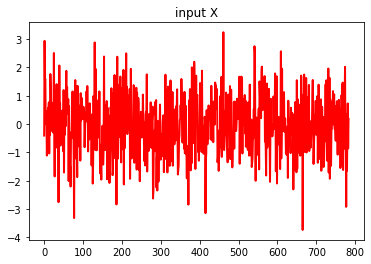

In [18]:
#An example of how to generate training data
def get_input_x():
    mu = 0  # The mean of the normal distribution
    sigma = 1  # Standard deviation of a normal distribution
    x = np.random.normal(mu, sigma, 784)
    return x
x=get_input_x()
plt.title("input X")
plt.plot(np.arange(0,len(x)), x, 'r-', linewidth=2)
plt.show()

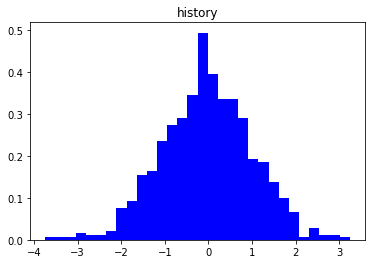

In [19]:
#Plot the histogram of the training data example above
plt.title('history')
plt.hist(x, 30,density=True,color='blue')
plt.show()

In [20]:
def get_input_x_0():
    mu = 0  # The mean of the normal distribution
    sigma = 1  # Standard deviation of a normal distribution
    x = np.random.normal(mu, sigma, (60000,784))
    return x
x_0=get_input_x_0()
x_0.shape

(60000, 784)

In [21]:
# Label, 1 means the array is created in normal distribution, 
# 0 means it is not created in normal distribution
y_0=np.zeros(60000)
y_0.shape

(60000,)

In [22]:
# Create dataset, x are the two arrays and y is label
from  sklearn.model_selection import train_test_split
train_x = np.concatenate([x_0], axis=0).astype(np.float32)
train_y = np.concatenate([y_0], axis=0).astype(np.float32)
train_x.shape

(60000, 784)

In [23]:
# split dataset into traing set and test set
# The random_state parameter controls how the pseudo-random number generator randomly 
# selects observations to go into the training set or test set.
x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,random_state=30)

# training dataset contains 45000 array samples and test set contains 15000 array samples.
x_train.shape

(45000, 784)

In [24]:
y_train

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [25]:
# TensorDataset is a ready to use class to represent your data as list of tensors.
# TensorDataset builds a dataset from a sequence of tensors
train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_dataset  = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

# Data is represented in the form of tensors
input_dims = (1, 28, 28)
label_size = 10
lam = 1e-06

train_dataset.input_dims = input_dims
train_dataset.input_size = int(np.prod(input_dims))
train_dataset.label_size = label_size
train_dataset.lam = lam
test_dataset.input_dims = input_dims
test_dataset.input_size = int(np.prod(input_dims))
test_dataset.label_size = label_size
test_dataset.lam = lam

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == 'cuda' else {}

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **kwargs)


In [26]:
train_and_evaluate(model, train_loader, test_loader, optimizer)

epoch   0 / 400, step    0 / 12; loss 1140.0757
Evaluate (epoch 0) -- logp(x) = -1136.963 +/- 0.364
epoch   1 / 400, step    0 / 12; loss 1135.4724
Evaluate (epoch 1) -- logp(x) = -1132.184 +/- 0.352
epoch   2 / 400, step    0 / 12; loss 1130.5262
Evaluate (epoch 2) -- logp(x) = -1129.176 +/- 0.346
epoch   3 / 400, step    0 / 12; loss 1128.3997
Evaluate (epoch 3) -- logp(x) = -1126.817 +/- 0.343
epoch   4 / 400, step    0 / 12; loss 1124.9623
Evaluate (epoch 4) -- logp(x) = -1124.913 +/- 0.341
epoch   5 / 400, step    0 / 12; loss 1123.3929
Evaluate (epoch 5) -- logp(x) = -1123.363 +/- 0.339
epoch   6 / 400, step    0 / 12; loss 1121.4598
Evaluate (epoch 6) -- logp(x) = -1122.085 +/- 0.338
epoch   7 / 400, step    0 / 12; loss 1120.5505
Evaluate (epoch 7) -- logp(x) = -1121.027 +/- 0.336
epoch   8 / 400, step    0 / 12; loss 1119.0128
Evaluate (epoch 8) -- logp(x) = -1120.142 +/- 0.335
epoch   9 / 400, step    0 / 12; loss 1117.7042
Evaluate (epoch 9) -- logp(x) = -1119.395 +/- 0.335


Evaluate (epoch 81) -- logp(x) = -1116.086 +/- 0.334
epoch  82 / 400, step    0 / 12; loss 1107.3240
Evaluate (epoch 82) -- logp(x) = -1116.131 +/- 0.335
epoch  83 / 400, step    0 / 12; loss 1107.8622
Evaluate (epoch 83) -- logp(x) = -1116.176 +/- 0.335
epoch  84 / 400, step    0 / 12; loss 1107.5751
Evaluate (epoch 84) -- logp(x) = -1116.216 +/- 0.335
epoch  85 / 400, step    0 / 12; loss 1107.2584
Evaluate (epoch 85) -- logp(x) = -1116.257 +/- 0.335
epoch  86 / 400, step    0 / 12; loss 1107.6079
Evaluate (epoch 86) -- logp(x) = -1116.301 +/- 0.335
epoch  87 / 400, step    0 / 12; loss 1107.7799
Evaluate (epoch 87) -- logp(x) = -1116.346 +/- 0.335
epoch  88 / 400, step    0 / 12; loss 1107.2427
Evaluate (epoch 88) -- logp(x) = -1116.393 +/- 0.335
epoch  89 / 400, step    0 / 12; loss 1107.2667
Evaluate (epoch 89) -- logp(x) = -1116.437 +/- 0.336
epoch  90 / 400, step    0 / 12; loss 1107.2052
Evaluate (epoch 90) -- logp(x) = -1116.479 +/- 0.336
epoch  91 / 400, step    0 / 12; loss 

epoch 162 / 400, step    0 / 12; loss 1104.5813
Evaluate (epoch 162) -- logp(x) = -1119.649 +/- 0.344
epoch 163 / 400, step    0 / 12; loss 1104.1938
Evaluate (epoch 163) -- logp(x) = -1119.682 +/- 0.344
epoch 164 / 400, step    0 / 12; loss 1104.9620
Evaluate (epoch 164) -- logp(x) = -1119.731 +/- 0.345
epoch 165 / 400, step    0 / 12; loss 1103.8744
Evaluate (epoch 165) -- logp(x) = -1119.769 +/- 0.345
epoch 166 / 400, step    0 / 12; loss 1104.4692
Evaluate (epoch 166) -- logp(x) = -1119.804 +/- 0.345
epoch 167 / 400, step    0 / 12; loss 1104.2898
Evaluate (epoch 167) -- logp(x) = -1119.844 +/- 0.345
epoch 168 / 400, step    0 / 12; loss 1103.6720
Evaluate (epoch 168) -- logp(x) = -1119.882 +/- 0.345
epoch 169 / 400, step    0 / 12; loss 1103.8402
Evaluate (epoch 169) -- logp(x) = -1119.912 +/- 0.345
epoch 170 / 400, step    0 / 12; loss 1104.5138
Evaluate (epoch 170) -- logp(x) = -1119.958 +/- 0.345
epoch 171 / 400, step    0 / 12; loss 1104.0918
Evaluate (epoch 171) -- logp(x) = 

Evaluate (epoch 242) -- logp(x) = -1122.314 +/- 0.351
epoch 243 / 400, step    0 / 12; loss 1102.1399
Evaluate (epoch 243) -- logp(x) = -1122.338 +/- 0.351
epoch 244 / 400, step    0 / 12; loss 1102.2661
Evaluate (epoch 244) -- logp(x) = -1122.373 +/- 0.351
epoch 245 / 400, step    0 / 12; loss 1102.0835
Evaluate (epoch 245) -- logp(x) = -1122.400 +/- 0.352
epoch 246 / 400, step    0 / 12; loss 1102.4359
Evaluate (epoch 246) -- logp(x) = -1122.428 +/- 0.352
epoch 247 / 400, step    0 / 12; loss 1102.0114
Evaluate (epoch 247) -- logp(x) = -1122.457 +/- 0.352
epoch 248 / 400, step    0 / 12; loss 1101.5085
Evaluate (epoch 248) -- logp(x) = -1122.483 +/- 0.352
epoch 249 / 400, step    0 / 12; loss 1102.3440
Evaluate (epoch 249) -- logp(x) = -1122.516 +/- 0.352
epoch 250 / 400, step    0 / 12; loss 1102.0657
Evaluate (epoch 250) -- logp(x) = -1122.547 +/- 0.352
epoch 251 / 400, step    0 / 12; loss 1102.0770
Evaluate (epoch 251) -- logp(x) = -1122.568 +/- 0.352
epoch 252 / 400, step    0 /

epoch 323 / 400, step    0 / 12; loss 1100.8245
Evaluate (epoch 323) -- logp(x) = -1124.349 +/- 0.357
epoch 324 / 400, step    0 / 12; loss 1101.0129
Evaluate (epoch 324) -- logp(x) = -1124.365 +/- 0.357
epoch 325 / 400, step    0 / 12; loss 1100.5006
Evaluate (epoch 325) -- logp(x) = -1124.395 +/- 0.357
epoch 326 / 400, step    0 / 12; loss 1100.0718
Evaluate (epoch 326) -- logp(x) = -1124.418 +/- 0.357
epoch 327 / 400, step    0 / 12; loss 1101.0156
Evaluate (epoch 327) -- logp(x) = -1124.443 +/- 0.357
epoch 328 / 400, step    0 / 12; loss 1100.5713
Evaluate (epoch 328) -- logp(x) = -1124.465 +/- 0.357
epoch 329 / 400, step    0 / 12; loss 1100.7858
Evaluate (epoch 329) -- logp(x) = -1124.488 +/- 0.357
epoch 330 / 400, step    0 / 12; loss 1100.7059
Evaluate (epoch 330) -- logp(x) = -1124.520 +/- 0.357
epoch 331 / 400, step    0 / 12; loss 1100.6499
Evaluate (epoch 331) -- logp(x) = -1124.531 +/- 0.357
epoch 332 / 400, step    0 / 12; loss 1100.3058
Evaluate (epoch 332) -- logp(x) = 

In [28]:
evaluate_model(model, test_dataloader, None)

Evaluate logp(x) = -18264.395 +/- 18.113


(tensor(-18264.3945), tensor(18.1130))

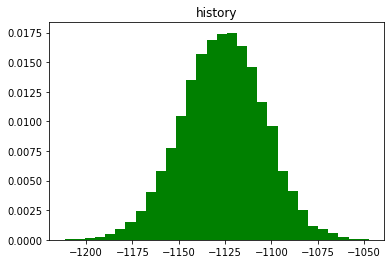

In [29]:
# Test model with normally distributed array which can modeled as a gravitational wave signal
samples=[]
for i in range(10000):
    x = np.random.normal(0, 1, 784)
    samples.append(x)
text_x=torch.from_numpy(np.array(samples).astype(np.float32))
kwargs = {'num_workers': 1, 'pin_memory': True} if device.type is 'cuda' else {}
text_x_loader = DataLoader(text_x, batch_size, shuffle=True, **kwargs)
# Compute the log probability
logprobs=[]
normal=0
with torch.no_grad():
    for data_x in text_x_loader:
        x = data_x.view(data_x.shape[0], -1).to(device)
        # use the normalizing flow model to get the result
        logprob=model.log_prob(x)
        # transfer into numpy format
        temp=logprob.detach().numpy()
        logprobs.append(logprob) 
logprobs = torch.cat(logprobs, dim=0).to(device)

# Histogram of a normally distributed array
x=logprobs.detach().numpy()
plt.title('history')
plt.hist(x, 30,density=True,color='green')
plt.show()

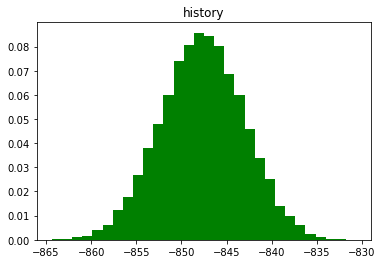

In [30]:
# Test model with non-normally distributed array which can modeled as noise
samples=[]
for i in range(10000):
    x = np.random.random(784)
    samples.append(x)
text_x=torch.from_numpy(np.array(samples).astype(np.float32))
kwargs = {'num_workers': 1, 'pin_memory': True} if device.type is 'cuda' else {}
text_x_loader = DataLoader(text_x, batch_size, shuffle=True, **kwargs)
# Compute the log probability
logprobs=[]
normal=0
with torch.no_grad():
    for data_x in text_x_loader:
        x = data_x.view(data_x.shape[0], -1).to(device)
        logprob=model.log_prob(x)
        temp=logprob.detach().numpy()
        logprobs.append(logprob) 
logprobs = torch.cat(logprobs, dim=0).to(device)

# Histogram of a non-normally distributed array
x=logprobs.detach().numpy()
plt.title('history')
plt.hist(x, 30,density=True,color='green')
plt.show()

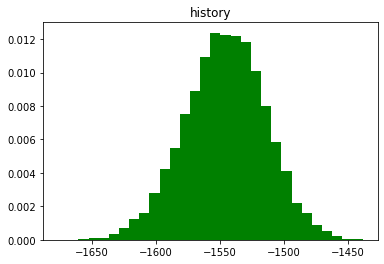

In [31]:
# Test model with non-normally distributed array which can modeled as noise
samples=[]
for i in range(10000):
    x = np.random.rayleigh(1,784)
    samples.append(x)
text_x=torch.from_numpy(np.array(samples).astype(np.float32))
kwargs = {'num_workers': 1, 'pin_memory': True} if device.type is 'cuda' else {}
text_x_loader = DataLoader(text_x, batch_size, shuffle=True, **kwargs)
# Compute the log probability
logprobs=[]
normal=0
with torch.no_grad():
    for data_x in text_x_loader:
        x = data_x.view(data_x.shape[0], -1).to(device)
        logprob=model.log_prob(x)
        temp=logprob.detach().numpy()
        logprobs.append(logprob) 
logprobs = torch.cat(logprobs, dim=0).to(device)

# Histogram of a non-normally distributed array
x=logprobs.detach().numpy()
plt.title('history')
plt.hist(x, 30,density=True,color='green')
plt.show()

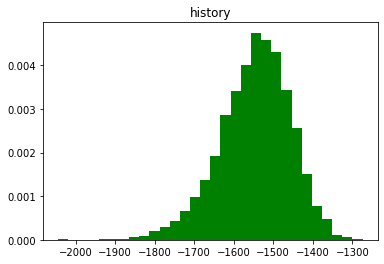

In [32]:
# Test model with non-normally distributed array which can modeled as noise
samples=[]
for i in range(10000):
    x = np.random.wald(1,1,784)
    samples.append(x)
text_x=torch.from_numpy(np.array(samples).astype(np.float32))
kwargs = {'num_workers': 1, 'pin_memory': True} if device.type is 'cuda' else {}
text_x_loader = DataLoader(text_x, batch_size, shuffle=True, **kwargs)
# Compute the log probability
logprobs=[]
normal=0
with torch.no_grad():
    for data_x in text_x_loader:
        x = data_x.view(data_x.shape[0], -1).to(device)
        logprob=model.log_prob(x)
        temp=logprob.detach().numpy()
        logprobs.append(logprob) 
logprobs = torch.cat(logprobs, dim=0).to(device)

# Histogram of a non-normally distributed array
x=logprobs.detach().numpy()
plt.title('history')
plt.hist(x, 30,density=True,color='green')
plt.show()